# Predicting Loan Defaults with PyCaret
## Dr José M Albornoz
### November 2024

This notebook presents an example of how Pycarer it used to tackle a binary classification problem. The dataset used is the [Lending Club dataset from Kaggle](https://www.kaggle.com/datasets/wordsforthewise/lending-club), as it contains a mixture of numeric, categorical, date and text features.

# 0.- Imports & utility functions

In [41]:
from pycaret.classification import *
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import cm
style.use('seaborn-colorblind')
%matplotlib inline

from sklearn.metrics import roc_curve

In [58]:
def plot_roc_thresholds(fpr, tpr, thresholds, step, fontsize=10, plotsize=7):

    """
    Plot a ROC curve with superposed threshold values

    Parameters:
        fpr (float): false positives rate
        tpr (float): true positives rate
        thresholds (float): decision thresholds
        step (integer): spacing at which the threshold values will be displayed in the plot
        fontsize (integer): font size for threshold values
        
    """

    # compute auc
    from sklearn.metrics import auc
    roc_auc = auc(fpr, tpr)

    # plot roc
    plt.figure(figsize=(plotsize,plotsize))
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic with Thresholds', y=1.08)
    plt.legend(loc="lower right")
    
    # creates threshold values and indexes for plotting 
    thresholds_sampled = thresholds[::step]
    idx_sampled = list(range(0, len(thresholds), step))
    idx = list(range(0, len(idx_sampled)))
    
    # Plot threshold points
    for i in idx:
        j = idx_sampled[i]
        t = thresholds_sampled[i]
        plt.annotate(f'{t:.2f}', (fpr[j], tpr[j]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=fontsize, color='red')

In [59]:
def plot_precision_recall_thresholds(y_true, y_scores, step, fontsize=10, plotsize=7):

    """
    Plot a precision-recall curve with superposed threshold values

    Parameters:
        y_true (float): true target value (1 or 0)
        y-scores (float): probability of the target being 1
        step (integer): spacing at which the threshold values will be displayed in the plot
        fontsize (integer): font size for threshold values
        
    """

    # Calculate precision, recall, and thresholds
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # creates threshold values and indexes for plotting 
    thresholds_sampled = thresholds[::step]
    idx_sampled = list(range(0, len(thresholds), step))
    idx = list(range(0, len(idx_sampled)))
    
    # Plot precision-recall curve
    plt.figure(figsize=(plotsize,plotsize))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # Plot threshold points
    for i in idx:
        j = idx_sampled[i]
        t = thresholds_sampled[i]
        plt.annotate(f'{t:.2f}', (recall[j], precision[j]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=fontsize, 
                     color='red')
    
    plt.legend()
    plt.title("Precision-Recall Curve with Thresholds", y=1.08)   

# 1.- Load data

In [4]:
# loading lending club dataset
import pandas as pd
data = pd.read_csv('../data/lendingclub.csv')

# sample so that only 10000 rows are considered (instead of 50000)
data = data.sample(10000, random_state=801).reset_index(drop=True)

# dropping features with no predictive power
data.drop(columns=['id', 'member_id', 'application_type'], inplace=True)
data.head()

,loan_amnt,funded_amnt,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,purpose,...,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,risky_loan
0,13000,13000,412.80,A,A5,Affordable Repairs,10.0,OWN,45600.0,car,...,10959,36.7,13,f,0,NaN,0,0.0,37875.0,not_risky
1,3000,3000,109.20,D,D2,Equinox Fitness,4.0,RENT,35000.0,moving,...,11643,71.9,16,f,0,NaN,0,0.0,43479.0,not_risky
2,35000,35000,1309.49,E,E1,Pure Water Technology,4.0,RENT,100000.0,debt_consolidation,...,16400,72.6,18,f,0,NaN,0,0.0,41315.0,not_risky
3,10000,10000,304.36,A,A1,Partners health care,10.0,MORTGAGE,140000.0,house,...,14874,28.5,35,f,0,NaN,0,NaN,NaN,not_risky
4,4750,4750,174.24,D,D4,US Airways,2.0,RENT,26000.0,major_purchase,...,2171,18.9,14,f,0,NaN,0,0.0,21204.0,not_risky


In [5]:
data.shape

(10000, 31)

## 1.1.- Feature types

In [6]:
data.dtypes

loan_amnt                        int64
funded_amnt                      int64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                     float64
home_ownership                  object
annual_inc                     float64
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                      int64
earliest_cr_line                object
inq_last_6mths                   int64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                         int64
pub_rec                          int64
revol_bal                        int64
revol_util                     float64
total_acc                        int64
initial_list_status             object
collections_12_mths_ex_me

## 1.2.- Split into numeric, categorical, date and text features

In [7]:
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], format='%b-%y')

In [8]:
numeric_features = list(data.select_dtypes(include=[np.number]).columns)
non_numeric_features = list(data.select_dtypes(exclude=[np.number]).columns)

In [9]:
data[numeric_features].dtypes

loan_amnt                        int64
funded_amnt                      int64
installment                    float64
emp_length                     float64
annual_inc                     float64
dti                            float64
delinq_2yrs                      int64
inq_last_6mths                   int64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                         int64
pub_rec                          int64
revol_bal                        int64
revol_util                     float64
total_acc                        int64
collections_12_mths_ex_med       int64
mths_since_last_major_derog    float64
acc_now_delinq                   int64
tot_coll_amt                   float64
tot_cur_bal                    float64
dtype: object

In [10]:
text_features = ['emp_title', 'title', 'zip_code', 'addr_state']

In [11]:
date_features = ['earliest_cr_line']

In [12]:
categorical_features = [var for var in non_numeric_features if var not in text_features and var not in date_features]

In [13]:
categorical_features.remove('risky_loan')

In [14]:
data[categorical_features].dtypes

grade                  object
sub_grade              object
home_ownership         object
purpose                object
initial_list_status    object
dtype: object

In [15]:
data[categorical_features].nunique()

grade                   7
sub_grade              35
home_ownership          5
purpose                13
initial_list_status     2
dtype: int64

In [16]:
data[text_features].dtypes

emp_title     object
title         object
zip_code      object
addr_state    object
dtype: object

In [17]:
data[text_features].nunique()

emp_title     8377
title         3983
zip_code       731
addr_state      45
dtype: int64

## 1.3.- Class Balance

In [23]:
data['risky_loan'].value_counts()*100/data.shape[0]

risky_loan
not_risky    83.56
risky        16.44
Name: count, dtype: float64

## 1.4.- Missing values

In [24]:
data.isnull().sum()

loan_amnt                         0
funded_amnt                       0
installment                       0
grade                             0
sub_grade                         0
emp_title                       541
emp_length                      338
home_ownership                    0
annual_inc                        0
purpose                           0
title                             0
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                       0
earliest_cr_line                  0
inq_last_6mths                    0
mths_since_last_delinq         5610
mths_since_last_record         9469
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                        8
total_acc                         0
initial_list_status               0
collections_12_mths_ex_med        0
mths_since_last_major_derog    8616
acc_now_delinq              

There isn't explicit support for imputing missing datetime or text values; imputation for these features can be managed by manual preprocessing before the data is fed to PyCaret. In this case we find that the text feature emp_title contains missing values, which we will manually impute using ‘N/A’.

In [25]:
# Impute missing values in text features with 'N/A'
data[text_features] = data[text_features].fillna('N/A')

# 2.- Experiment Setup

In [26]:
from sklearn.model_selection import train_test_split

#Split the dataset into training and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=801)

In [27]:
clf = setup(data=train_data, target = 'risky_loan', session_id = 801, 
            numeric_features = numeric_features,
            categorical_features = categorical_features,
            text_features = text_features, 
            date_features = date_features,
            fold = 5, numeric_imputation = 'median', normalize = True, fix_imbalance=True 
           )

,Description,Value
0,Session id,801
1,Target,risky_loan
2,Target type,Binary
3,Target mapping,"not_risky: 0, risky: 1"
4,Original data shape,"(7000, 31)"
5,Transformed data shape,"(10320, 6512)"
6,Transformed train set shape,"(8220, 6512)"
7,Transformed test set shape,"(2100, 6512)"
8,Numeric features,20
9,Date features,1


## 2.1.- Model Build

In this project we want to train a number of models in order to select the one with the highest AUC. Performing this task is a matter of running a single line of code containing the `compare_models` function. This is where the power of PyCaret shines: all classification estimators available in PyCaret will be trained and evaluated using the 5-fold cross-validation criteria we have specified. PyCaret will generate a table with metrics for all the available estimators; this table can be sorted by specifying a metric in the call to `compare_models` (AUC in our case).

In [28]:
best = compare_models(n_select = 5, sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8312,0.6273,0.8312,0.7331,0.7658,0.0051,0.0085,6.1680
rf,Random Forest Classifier,0.8378,0.6167,0.8378,0.7469,0.7663,0.0047,0.0177,2.8520
lightgbm,Light Gradient Boosting Machine,0.8263,0.6116,0.8263,0.7430,0.7684,0.0208,0.0321,3.2560
et,Extra Trees Classifier,0.8369,0.6099,0.8369,0.7033,0.7643,-0.0036,-0.0184,3.2600
ada,Ada Boost Classifier,0.8016,0.6000,0.8016,0.7380,0.7628,0.0230,0.0268,4.1600
xgboost,Extreme Gradient Boosting,0.8212,0.5984,0.8212,0.7420,0.7682,0.0246,0.0336,4.1260
svm,SVM - Linear Kernel,0.8167,0.5608,0.8167,0.7451,0.7695,0.0364,0.0458,2.9200
lr,Logistic Regression,0.6882,0.5442,0.6882,0.7348,0.7089,0.0180,0.0186,3.3040
dt,Decision Tree Classifier,0.7737,0.5369,0.7737,0.7526,0.7619,0.0819,0.0835,2.4900
qda,Quadratic Discriminant Analysis,0.8388,0.5251,0.8388,0.7035,0.7652,0.0000,0.0000,22.3920


The model that resulted in the highest AUC is the Gradient Boosting Classifier. To see all available estimators we can use the `models` function.

In [29]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


We would like to examine the ROC plot for the best performer. We can do this quite easily using the plotting functions included in PyCaret.

## 2.2.- ROC Plot

The `best` object returned by `compare_models` is a list that contains all the models trained by PyCaret. To obtain the best performing model, we retrieve the first element of the best list. For example, we would like to examine the ROC plot for the best performer. We can do this quite easily using the plotting functions included in PyCaret.

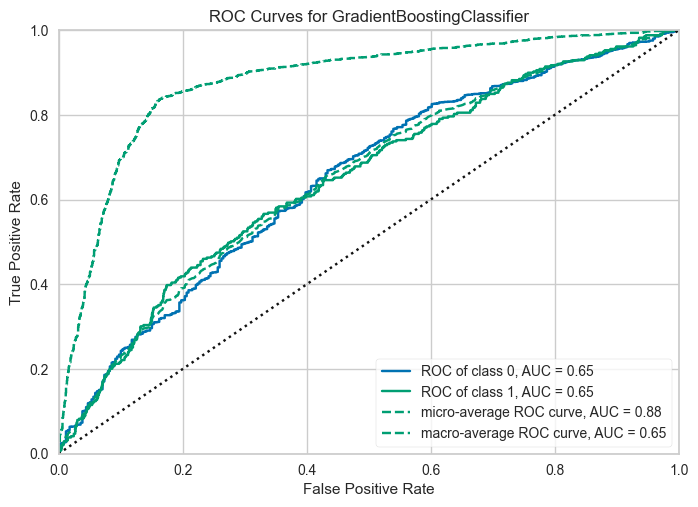

In [30]:
# plot AUC
plot_model(best[0], plot = 'auc')

We will generate another ROC plot taking advantage of the utility functions defined at the start of this notebook.

In [47]:
X_test_transformed = get_config('X_test_transformed')

In [48]:
probs = best[0].predict_proba(X_test_transformed)[:,1]

In [49]:
y_true = get_config('y_test_transformed').to_numpy()

In [50]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_true, probs)

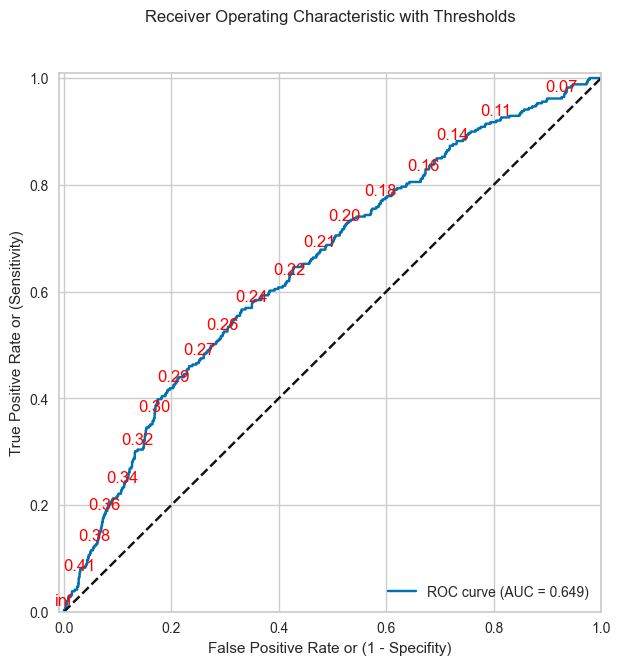

In [60]:
plot_roc_thresholds(fpr, tpr, thresholds, 30, fontsize=12, plotsize=7)

## 2.3.- Plot precision-recall curve

We now generate precision-recall curves using both PyCaret's plotting function as well as the utility function previously defined.

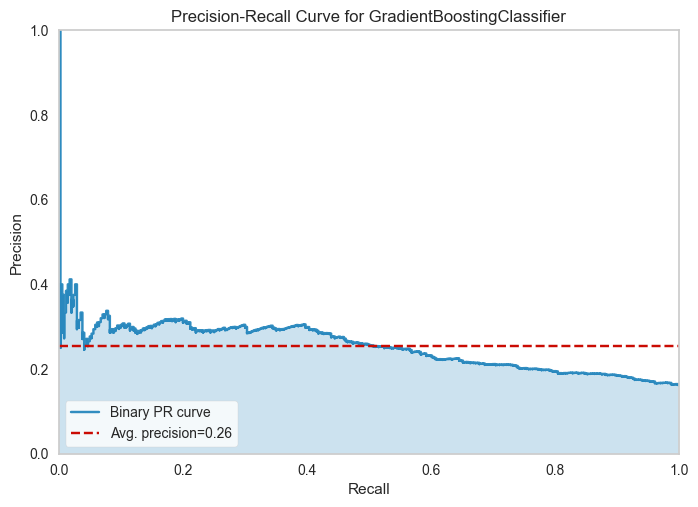

In [61]:
# plot precision-recall using pycaret's plotting 
plot_model(best[0], plot = 'pr')

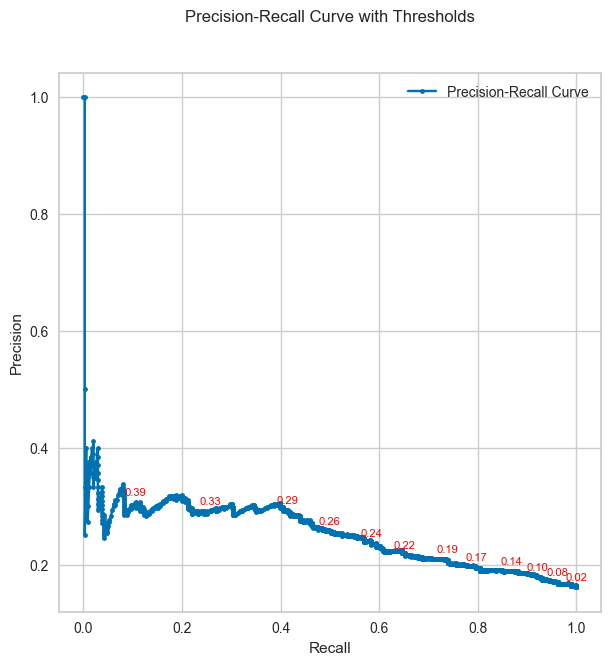

In [63]:
plot_precision_recall_thresholds(y_true, probs, 180, 8, plotsize=7)

## 2.4- Plot confusion matrix

For the sake of this example, we are going to change the decision threshold of the model with the highest AUC.

In [64]:
gbc0 = create_model('gbc', fold = 5, probability_threshold = 0.22)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5592,0.6198,0.5592,0.7609,0.6174,0.0695,0.0898
1,0.5765,0.6103,0.5765,0.7669,0.6325,0.0861,0.1091
2,0.5571,0.6201,0.5571,0.7732,0.6152,0.0917,0.1216
3,0.5653,0.6468,0.5653,0.7767,0.6225,0.1008,0.1326
4,0.5765,0.6398,0.5765,0.7899,0.6322,0.1277,0.1688
Mean,0.5669,0.6273,0.5669,0.7735,0.6240,0.0951,0.1244
Std,0.0083,0.0137,0.0083,0.0098,0.0072,0.0192,0.0264


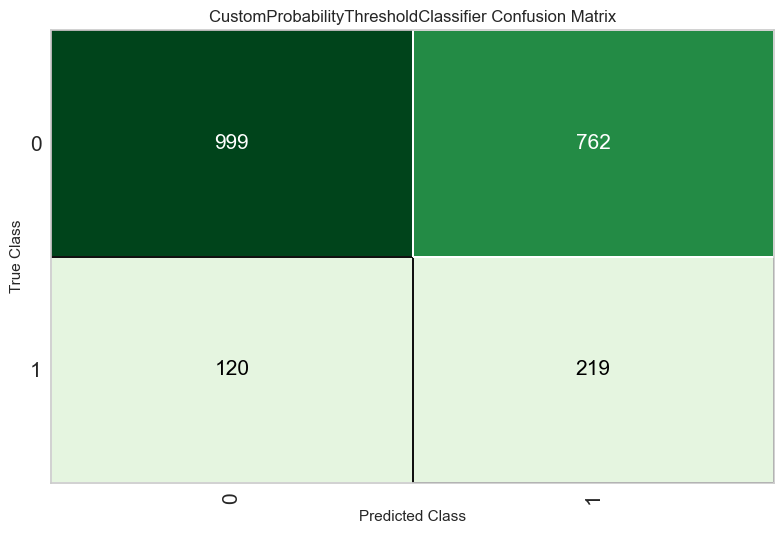

In [65]:
# plot confusion matrix
plot_model(gbc0, plot = 'confusion_matrix')

## 2.5.- Hyperparameter tuning

In [66]:
# tune model to optimise AUC
tuned_gbc = tune_model(gbc0, optimize = 'AUC', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.1612,0.6000,0.1612,0.0260,0.0448,0.0000,0.0000
1,0.1612,0.5993,0.1612,0.0260,0.0448,0.0000,0.0000
2,0.1612,0.6325,0.1612,0.0260,0.0448,0.0000,0.0000
3,0.1612,0.6193,0.1612,0.0260,0.0448,0.0000,0.0000
4,0.1612,0.6322,0.1612,0.0260,0.0448,0.0000,0.0000
Mean,0.1612,0.6167,0.1612,0.0260,0.0448,0.0000,0.0000
Std,0.0000,0.0147,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


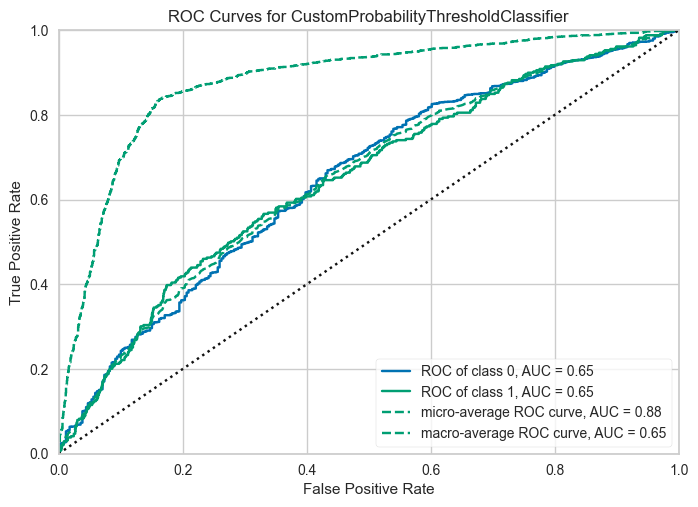

In [67]:
# plot AUC
plot_model(tuned_gbc, plot = 'auc')

In [68]:
y_scores = tuned_gbc.predict_proba(X_test_transformed)[:,1]

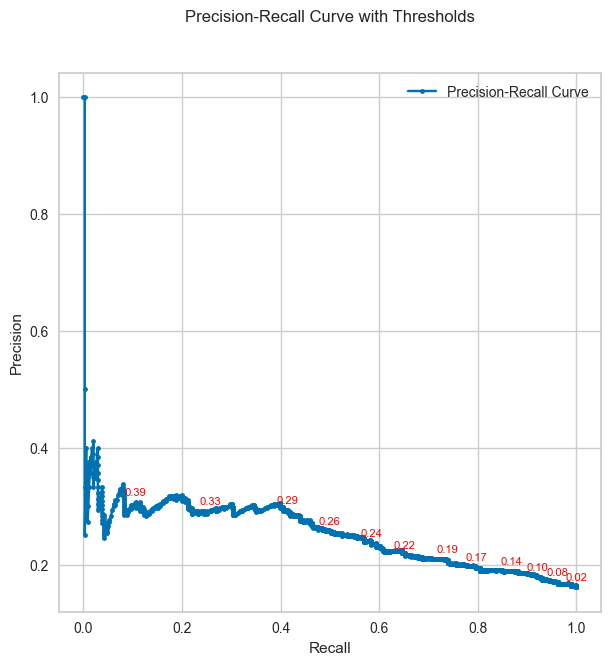

In [72]:
plot_precision_recall_thresholds(y_true, y_scores, 180, 8)

Let's plot the confusion matrix for the tuned model for the same threshold we used before (0.22)

In [73]:
y_pred = []
threshold = 0.22
for val in y_scores:
    if val >= threshold:
        y_pred.append(1)
    else:
        y_pred.append(0)

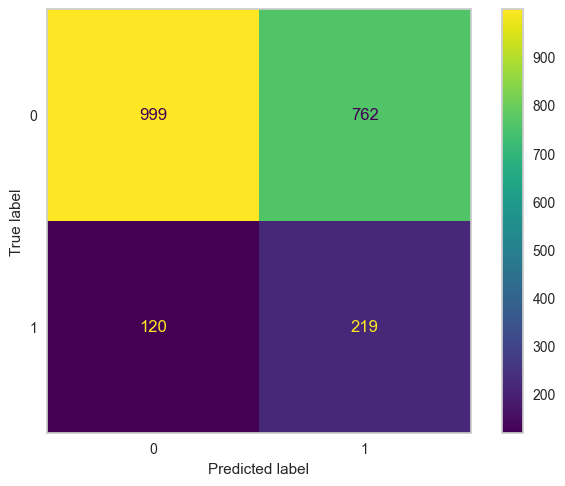

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, labels=tuned_gbc.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_gbc.classes_).plot()
plt.grid(False)

An alternative to `plot_model` function is `evaluate_model`. It can only be used in Notebook since it uses `ipywidget`.

In [75]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# 3.- Prediction

The `predict_model` function returns `prediction_label` and `prediction_score` (probability of the predicted class) as new columns in dataframe. When data is `None` (default), it uses the test set (created during the setup function) for scoring.

In [79]:
# predict on test set
holdout_pred = predict_model(tuned_gbc, data = test_data, probability_threshold = 0.22)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5663,0.6357,0.5663,0.7708,0.6192,0.1148,0.1493


In [80]:
# show predictions df
holdout_pred.head()

,loan_amnt,funded_amnt,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,purpose,...,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,risky_loan,prediction_label,prediction_score
6859,3000,3000,97.029999,B,B1,TUSTIN CARS INC,10.0,RENT,47000.0,other,...,11,f,0,NaN,0,0.0,12373.0,risky,not_risky,0.8500
7869,7300,7300,189.570007,D,D4,American Computer Net,1.0,MORTGAGE,35000.0,debt_consolidation,...,11,f,0,NaN,0,103.0,66907.0,not_risky,risky,0.3233
9007,3500,3500,119.779999,B,B5,CCS INC,7.0,RENT,27000.0,vacation,...,6,f,0,NaN,0,0.0,7732.0,not_risky,risky,0.2794
2542,15000,15000,476.299988,A,A5,Market America,10.0,RENT,170000.0,debt_consolidation,...,41,f,0,NaN,0,0.0,1124.0,not_risky,not_risky,0.9429
3233,14825,14825,530.549988,C,C5,Department of Homeland Security,4.0,MORTGAGE,95000.0,credit_card,...,32,f,0,NaN,0,NaN,NaN,not_risky,not_risky,0.8675


# 4.- Save model

Finally, you can save the entire pipeline on disk as a pickle file for later use, using PyCaret's `save_model` function.

In [81]:
# save pipeline
save_model(tuned_gbc, 'lending_club_model_v1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['earliest_cr_line'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(excl...
                                                       learning_rate=0.1,
                                                       loss='log_loss',
                                                       max_depth=3,
                                                       max_features=No

In [82]:
# load pipeline
loaded_best_pipeline = load_model('lending_club_model_v1')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/var/folders/wf/3tthnv696c766yz5blpdyy1h0000gp/T/joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['earliest_cr_line'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',...
                                                      learning_rate=0.1,
                                                      loss='log_loss',
                                                      max_depth=3,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100,
                                                      n_iter_no_change=None,
                                                      probability_threshold=0.22,
                                                      random_state=801,
                                                      subsample=1.0, tol=0.0001,
                                                      validation_fraction=0.1,
                                                      verbose=0,
                                                      warm_start=False))],
         verbose=False)